<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: ELASTiCC data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Load data

Let's assume you downloaded data from the Fink Data Transfer service. You can read the data using pandas:

In [2]:
pdf = pd.read_parquet('ftransfer_elasticc_2023-02-08_902820/')

In [3]:
pdf.head(3)

,alertId,diaSource,prvDiaSources,prvDiaForcedSources,prvDiaNondetectionLimits,diaObject,cutoutDifference,cutoutTemplate,brokerIngestTimestamp,timestamp,...,PEAKMAG_Y,SNRMAX,SNRMAX2,SNRMAX3,NOBS,NOBS_SATURATE,year,month,day,classId
0,2688144076,"{'ccdVisitId': -1, 'decl': -44.57368815663484,...","[{'ccdVisitId': -1, 'decl': -44.57368815663484...","[{'ccdVisitId': -7259234415925615358, 'diaForc...",None,"{'decl': -44.57368815663484, 'diaObjectId': 13...",None,None,2022-12-01 21:25:03.701628+00:00,2025-09-11 08:53:34.08,...,22.8513,12.2434,8.44016,8.38762,179,0,2025,9,11,111
1,2688144077,"{'ccdVisitId': -1, 'decl': -44.57368815663484,...","[{'ccdVisitId': -1, 'decl': -44.57368815663484...","[{'ccdVisitId': -7259234415925615358, 'diaForc...",None,"{'decl': -44.57368815663484, 'diaObjectId': 13...",None,None,2022-12-01 21:27:04.881073+00:00,2025-09-11 09:27:59.04,...,22.8513,12.2434,8.44016,8.38762,179,0,2025,9,11,111
2,7732192044,"{'ccdVisitId': -1, 'decl': -33.46785888824701,...","[{'ccdVisitId': -1, 'decl': -33.46785888824701...","[{'ccdVisitId': -4582528285002829610, 'diaForc...",None,"{'decl': -33.46785888824701, 'diaObjectId': 38...",None,None,2022-12-01 21:28:02.905111+00:00,2025-09-11 10:03:33.12,...,22.4860,34.7671,23.16600,19.67490,188,0,2025,9,11,111


## Reconstruct alert light-curves

In [4]:
def extract_history(history_list: list, field: str) -> list:
    """Extract the historical measurements contained in the alerts
    for the parameter `field`.

    Parameters
    ----------
    history_list: list of dict
        List of dictionary from alert[history].
    field: str
        The field name for which you want to extract the data. It must be
        a key of elements of history_list
    
    Returns
    ----------
    measurement: list
        List of all the `field` measurements contained in the alerts.
    """
    if history_list is None:
        return []
    try:
        measurement = [obs[field] for obs in history_list]
    except KeyError:
        print('{} not in history data'.format(field))
        measurement = []

    return measurement

def extract_field(alert: dict, category: str, field: str) -> np.array:
    """ Concatenate current and historical observation data for a given field.
    
    Parameters
    ----------
    alert: dict
        Dictionnary containing alert data
    category: str
        prvDiaSources or prvDiaForcedSources
    field: str
        Name of the field to extract.
    
    Returns
    ----------
    data: np.array
        List containing previous measurements and current measurement at the
        end. If `field` is not in the category, data will be
        [alert['diaSource'][field]].
    """
    data = np.concatenate(
        [
            [alert["diaSource"][field]],
            extract_history(alert[category], field)
        ]
    )
    return data

In [5]:
pdf['cpsFlux'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFlux'), axis=1)
pdf['cpsFluxErr'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFluxErr'), axis=1)
pdf['cfilterName'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'filterName'), axis=1)
pdf['cmidPointTai'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'midPointTai'), axis=1)

cols = ['alertId', 'classId', 'cmidPointTai', 'cpsFlux', 'cpsFluxErr', 'cfilterName']
sub = pdf[cols]
sub

,alertId,classId,cmidPointTai,cpsFlux,cpsFluxErr,cfilterName
0,2688144076,111,"[60929.2872, 60872.4282, 60872.4379, 60873.336...","[2820.39453125, -5.057952880859375, -231.24731...","[620.8955688476562, 589.9527587890625, 819.350...","[i, i, z, r, i, r, r, i, i, r, r, r, i, r, i, ..."
1,2688144077,111,"[60929.3111, 60872.4282, 60872.4379, 60873.336...","[2545.942138671875, -5.057952880859375, -231.2...","[526.3256225585938, 589.9527587890625, 819.350...","[z, i, z, r, i, r, r, i, i, r, r, r, i, r, i, ..."
2,7732192044,111,"[60929.3358, 60892.4291, 60893.411, 60893.4222...","[4243.78271484375, -46.44723892211914, -321.46...","[555.7435302734375, 258.25811767578125, 288.08...","[z, r, i, z, Y, Y, Y, Y, z, Y, z, i, z, i, z, ..."
3,18412642052,111,"[60929.3428, 60881.4374, 60882.4281, 60882.429...","[3685.929443359375, -129.65621948242188, -175....","[694.65673828125, 246.22593688964844, 181.5370...","[z, r, r, r, Y, i, r, z, i, z, Y, i, z, Y, Y, ..."
4,3575266008,111,"[60929.3961, 60897.3409, 60897.3546, 60897.364...","[5095.92724609375, 2931.457275390625, 875.0927...","[498.1011962890625, 1342.47705078125, 1276.319...","[z, Y, Y, Y, Y, g, r, Y, Y]"
...,...,...,...,...,...,...
20431,128840828125,221,"[60929.3612, 60277.1573, 60282.1467, 60282.171...","[11522.45703125, -977.6087036132812, -719.9767...","[1072.29052734375, 440.21221923828125, 214.186...","[Y, i, r, g, u, r, i, r, z, i, i, z, z, Y, Y, ..."
20432,128840828124,221,"[60929.338, 60277.1573, 60282.1467, 60282.1713...","[11854.7568359375, -977.6087036132812, -719.97...","[514.26708984375, 440.21221923828125, 214.1861...","[z, i, r, g, u, r, i, r, z, i, i, z, z, Y, Y, ..."
20433,133782780147,221,"[60929.3975, 60285.1949, 60285.2184, 60287.072...","[-10525.1630859375, 2073.27099609375, 3291.073...","[592.8213500976562, 351.14801025390625, 1179.8...","[z, g, u, r, r, u, r, i, z, z, Y, Y, Y, i, i, ..."
20434,129867096146,221,"[60929.2953, 60449.4347, 60484.3008, 60484.345...","[4529.18017578125, 2772.90087890625, 1957.8807...","[557.035888671875, 312.96630859375, 773.464599...","[i, i, z, Y, r, i, i, i, z, Y, z, r, i, g, r, ..."


## Do some plots

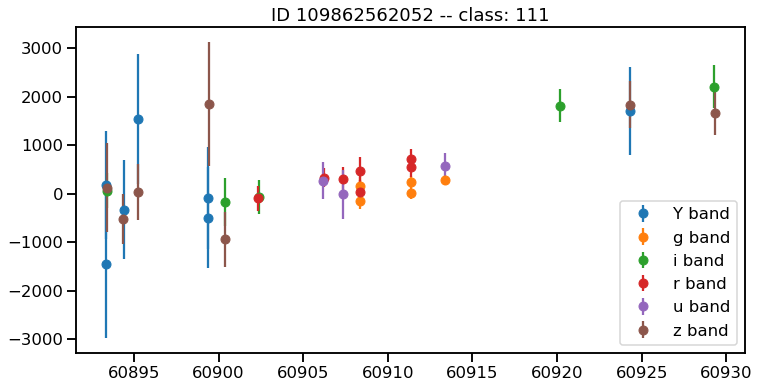

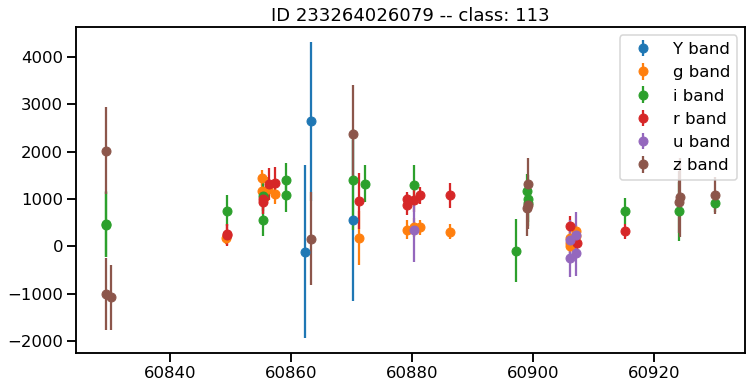

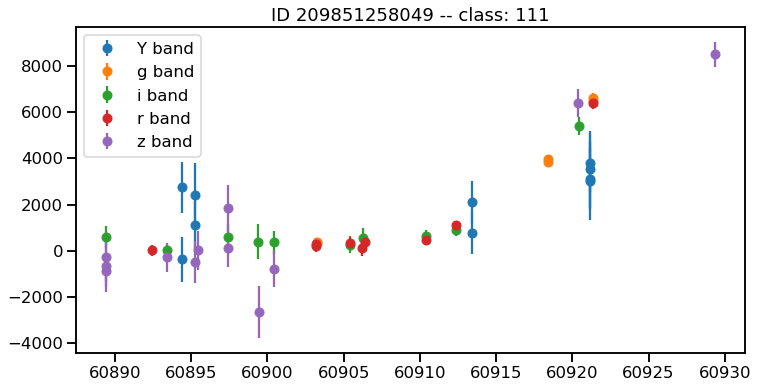

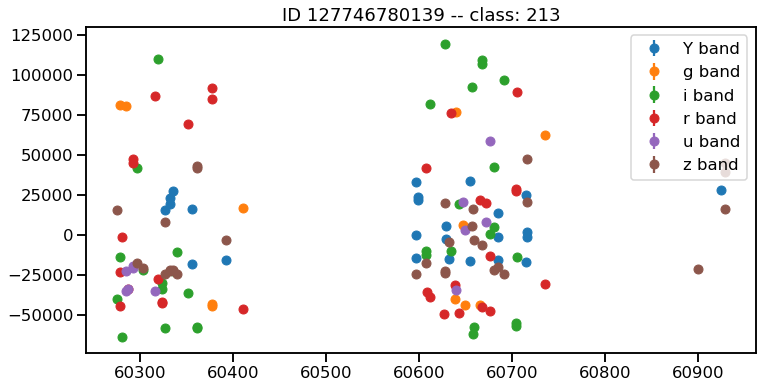

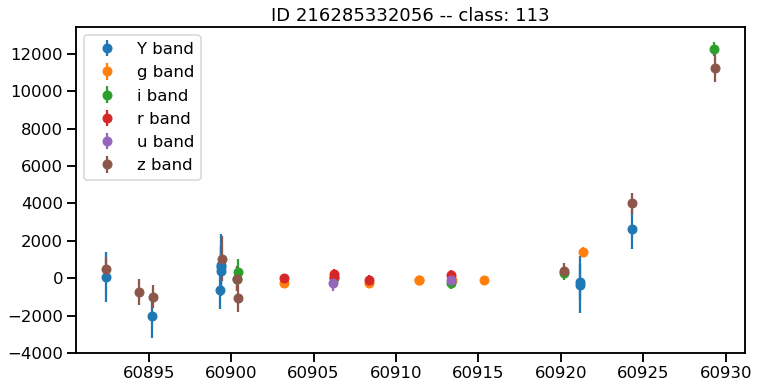

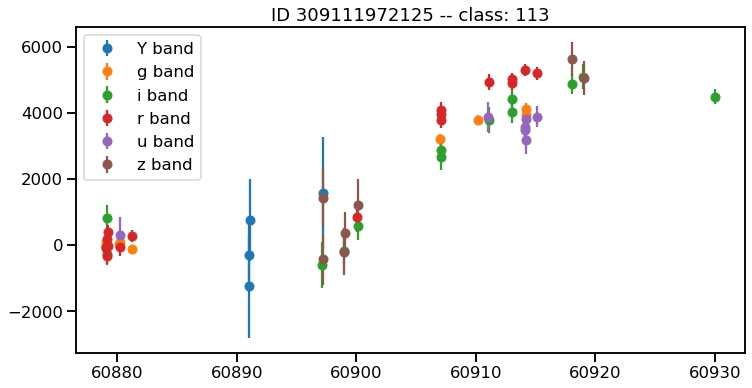

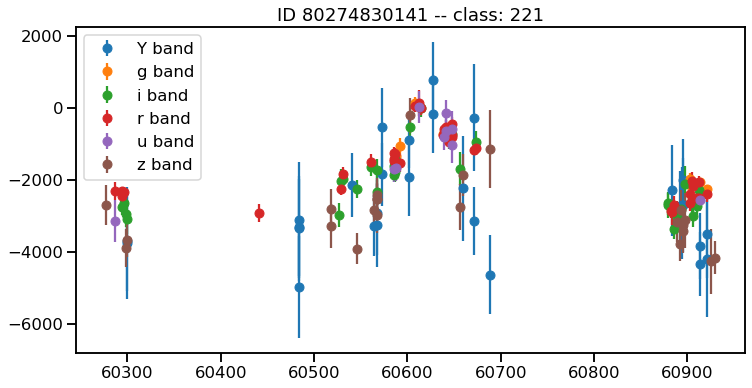

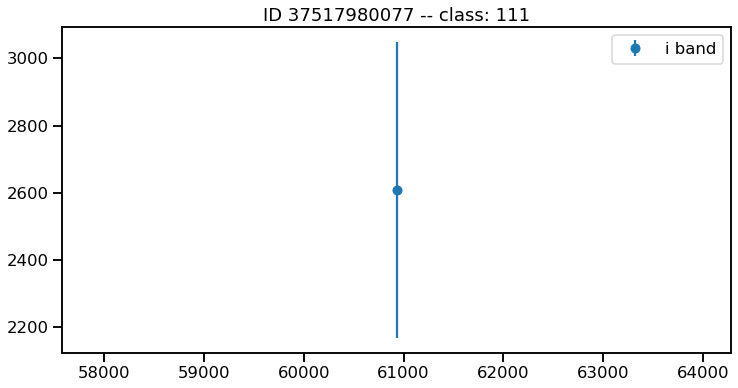

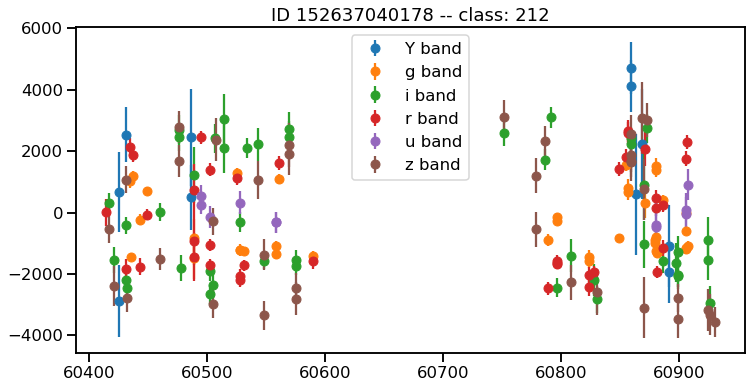

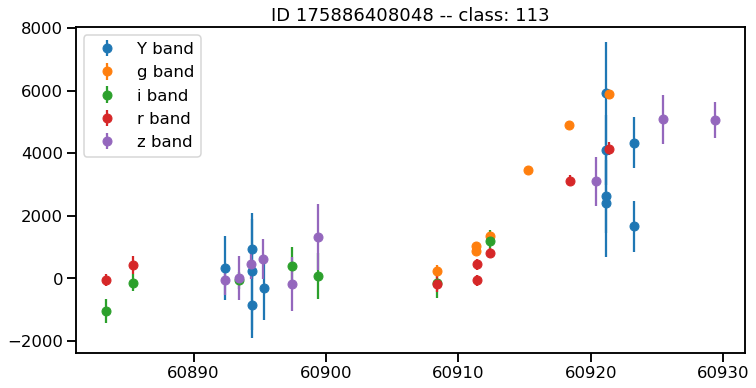

In [6]:
N = 10
seed = np.random.seed(1)
indices = np.random.randint(0, len(sub), N)

for index in indices:
    fig = plt.figure(figsize=(12, 6))
    
    data = sub.iloc[index]
    filters = np.unique(data['cfilterName'])
    
    for filt in filters:
        cond = data['cfilterName'] == filt
        
        plt.errorbar(
            data['cmidPointTai'][cond], 
            data['cpsFlux'][cond], 
            data['cpsFluxErr'][cond],
            ls='',
            marker='o',
            label='{} band'.format(filt)
        )
    plt.title('ID {} -- class: {}'.format(data['alertId'], data['classId']))
    plt.legend()
    plt.show()

You can find the mapping to the taxonomy at https://github.com/LSSTDESC/elasticc/blob/main/taxonomy/taxonomy.ipynb